This notebook reads data from the `out` folder and visualizes the results of the JoularJX .csv files with matplotlib and seaborn.

First, we import the necessary libraries.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np

The we add some configuration for later calculations.

In [8]:
CONFIGS = {
    "local": {
        "carbon_intensity": 0.042, # kgCO2eq/kWh (Switzerland average)
        "embodied_emission": 41.5, # kgCO2eq
        "expected_lifetime_years": 4, # years
        "used_vcpus": 8,
        "total_vcpus": 12,
    },
    "scaleway": {
        "carbon_intensity": 0.064, # kgCO2eq/kWh (France average)
        "embodied_emission": 36.5, # kgCO2eq
        "expected_lifetime_years": 4,
        "used_vcpus": 8,
        "total_vcpus": 12,
    }
}

SECONDS_PER_YEAR = 365 * 24 * 60 * 60
JOULES_PER_KWH = 3_600_000

We define how diagrams should look like.

In [9]:
def plot_boxplot(
        data,
        x_axis=None,
        y_axis=None,
        x_label=None,
        y_label=None,
        title=None
):
    sns.set_theme(style="whitegrid", context="talk", palette="colorblind")
    fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

    sns.boxplot(
        x=x_axis,
        y=y_axis,
        data=data,
        ax=ax,
        width=0.6
    )

    sns.swarmplot(
        x=x_axis,
        y=y_axis,
        data=data,
        color="black",
        size=5,
        alpha=0.7,
        ax=ax
    )

    sns.despine(ax=ax, offset=10, trim=True)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title,
                 fontsize=16,
                 fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=11)

    fig.tight_layout()
    return fig


def plot_barplot(
        data,
        x_axis=None,
        y_axis=None,
        hue=None,
        x_label=None,
        y_label=None,
        title=None
):
    sns.set_theme(style="whitegrid", context="talk", palette="colorblind")
    fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

    sns.barplot(
        x=x_axis,
        y=y_axis,
        hue=hue,
        data=data,
        ax=ax
    )

    sns.despine(ax=ax, offset=10, trim=True)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title,
                 fontsize=16,
                 fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=11)
    ax.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')

    fig.tight_layout()
    return fig


def plot_comparative_boxplot(
        data,
        x_axis=None,
        y_axis=None,
        hue=None,
        x_label=None,
        y_label=None,
        title=None,
        include_experiments=None,
        include_services=None,
        legend=True
):
    data_filtered = data.copy()
    if include_experiments:
        data_filtered = data_filtered[data_filtered["experiment"].isin(include_experiments)]
    if include_services:
        data_filtered = data_filtered[data_filtered["service"].isin(include_services)]
    if data_filtered.empty:
        return

    experiment_order = include_experiments or sorted(data_filtered["experiment"].unique())
    order = experiment_order
    if include_services:
        service_order = include_services or sorted(data_filtered["service"].unique())
        order = service_order


    sns.set_theme(style="whitegrid", context="talk", palette="colorblind")
    fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

    sns.boxplot(
        x=x_axis,
        y=y_axis,
        hue=hue,
        data=data_filtered,
        order=order,
        hue_order=experiment_order,
        ax=ax,
        dodge=True,
        width=0.6
    )

    sns.swarmplot(
        x=x_axis,
        y=y_axis,
        hue=hue,
        data=data_filtered,
        order=order,
        hue_order=experiment_order,
        dodge=True,
        size=4,
        alpha=0.7,
        ax=ax,
        legend=legend
    )

    sns.despine(ax=ax, offset=10, trim=True)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=11)
    ax.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc="upper left")

    fig.tight_layout()
    return fig


def plot_experiment_comparison_boxplot(
        data,
        x_axis=None,
        y_axis=None,
        x_label=None,
        y_label=None,
        title=None,
        include_experiments=None,
):
    data_filtered = data.copy()
    if include_experiments:
        data_filtered = data_filtered[data_filtered["experiment"].isin(include_experiments)]
    if data_filtered.empty:
        return None

    experiment_order = include_experiments or sorted(data_filtered["experiment"].unique())

    sns.set_theme(style="whitegrid", context="talk", palette="colorblind")
    fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

    # Boxplot (one box per experiment, no hue)
    sns.boxplot(
        x=x_axis,
        y=y_axis,
        data=data_filtered,
        order=experiment_order,
        ax=ax,
        width=0.6
    )

    # Overlay individual data points
    sns.swarmplot(
        x=x_axis,
        y=y_axis,
        data=data_filtered,
        order=experiment_order,
        color="black",
        size=5,
        alpha=0.7,
        ax=ax
    )

    sns.despine(ax=ax, offset=10, trim=True)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.tick_params(axis="x", rotation=45, labelsize=11)

    fig.tight_layout()
    return fig


def plot_comparative_barplot(
        data,
        x_axis=None,
        y_axis=None,
        hue=None,
        x_label=None,
        y_label=None,
        title=None,
        include_experiments=None,
        include_services=None,
        include_methods=None
):

    data_filtered = data.copy()
    if include_experiments:
        data_filtered = data_filtered[data_filtered["experiment"].isin(include_experiments)]
    if include_services:
        data_filtered = data_filtered[data_filtered["service"].isin(include_services)]
    if include_methods:
        data_filtered = data_filtered[data_filtered["method"].isin(include_methods)]
    if data_filtered.empty:
            return

    sns.set_theme(style="whitegrid", context="talk", palette="colorblind")
    fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

    sns.barplot(
        x=x_axis,
        y=y_axis,
        hue=hue,
        data=data_filtered,
        ax=ax,
        dodge=True,
        legend=True
    )

    sns.despine(ax=ax, offset=10, trim=True)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_title(title,
                 fontsize=16,
                 fontweight="bold")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc="upper left")
    fig.tight_layout()
    return fig


Save the generated plot as PNG and SVG files.

In [17]:
def save_plot(
        figure: plt.Figure,
        plot_folder,
        plot_name,
):
    os.makedirs(plot_folder, exist_ok=True)

    png_path = os.path.join(plot_folder, f"{plot_name}.png")
    svg_path = os.path.join(plot_folder, f"{plot_name}.svg")

    figure.savefig(png_path, dpi=300, bbox_inches="tight")
    figure.savefig(svg_path, bbox_inches="tight")
    plt.close(figure)

The `local` or `scaleway` folder contains the results all experiments.
Each experiment folder contains multiple test executions, containing multiple .csv files, one for each LakesideMutual service.

1. customer-core
2. customer-management
3. customer-self-service
4. policy-management

The generated files are named as follows: joularjx-\<id\>-filtered-methods-energy.csv, where \<id>\ is a generated joularjx id.
Each .csv file has two columns, the first column contains method names in the format com.lakesidemutual.\<servicename\>.interfaces.\<class\>.\<method\> and the second column contains the total energy consumption in Joules for that method.
Each row represents a method and the energy consumption for its execution.

We want to read all joularjx-\<id\>-filtered-methods-energy.csv from the `out/<test-run-identifier>` folders, then access the first column to extract the service name and the method name, and the second column to access the energy consumption.
The delimiter in the .csv files is a comma.
We store the data in a two level dictionary, where the first level key is the service name and the second level key is the method name, and the value is the energy consumption for that method.

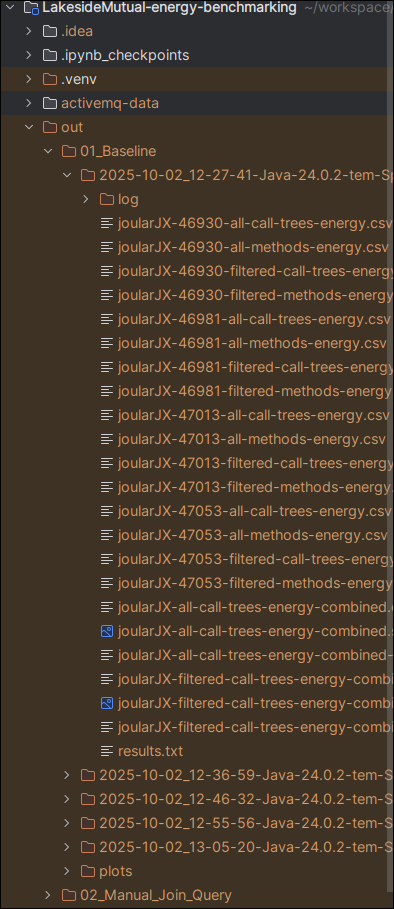

In [14]:
out_folder = 'local'
environment = "local" if "local" in out_folder.lower() else "scaleway"
config = CONFIGS[environment]

csv_files = []
result_files = []
for root, dirs, files in os.walk(out_folder):
    for file in files:
        if file.endswith('-filtered-methods-energy.csv'):
            csv_files.append(os.path.relpath(os.path.join(root, file), out_folder)) # Store relative path to out_folder
        if file.endswith('results.txt'):
            result_files.append(os.path.relpath(os.path.join(root, file), out_folder))

csv_files.sort()
result_files.sort()

# Combined regex for all methods to exclude
exclude_pattern = re.compile(r"^(?:<init>|setCallbacks|apply|lambda.*|CGLIB\$.*)$")

experiments_data = {}
for csv_file in csv_files:
    parts = csv_file.split(os.sep)
    if len(parts) < 2:
        continue  # skip any unexpected file structure

    experiment_id = parts[0]
    test_run_id = parts[1]

    experiments_data.setdefault(experiment_id, {})
    experiments_data[experiment_id].setdefault(test_run_id, {})

    df = pd.read_csv(
        os.path.join(out_folder, csv_file),
        delimiter=',',
        header=None,
        names=['method_full', 'energy']
    )

    for _, row in df.iterrows():
        try:
            parts = row['method_full'].split('.')
            service_name = parts[2]  # com.lakesidemutual.<service>
            method_name = parts[-1]  # last element
        except IndexError:
            continue  # skip malformed rows

        if exclude_pattern.match(method_name):
            continue # Exclude methods by regex pattern

        experiments_data[experiment_id][test_run_id].setdefault(service_name, {})
        experiments_data[experiment_id][test_run_id][service_name][method_name] = row['energy']


results_data = {}
execution_times = {}
for root, dirs, files in os.walk(out_folder):
    for file in files:
        if file == "results.txt":
            rel_path = os.path.relpath(os.path.join(root, file), out_folder)
            parts = rel_path.split(os.sep)

            if len(parts) < 2:
                continue  # skip any unexpected file structure

            experiment_id = parts[0]
            test_run_id = parts[1]

            results_data.setdefault(experiment_id, {})
            results_data[experiment_id].setdefault(test_run_id, {})
            execution_times.setdefault(experiment_id, {})

            results_path = os.path.join(root, file)
            with open(results_path, "r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()

                    if line.startswith("Joules "):
                        try:
                            # Format: "Joules <service_name>: <value>"
                            prefix, rest = line.split("Joules ", 1)
                            service_part, energy_part = rest.split(":")
                            service_name = service_part.strip()
                            energy_value = float(energy_part.strip())
                        except ValueError:
                            continue  # skip malformed lines

                        normalized_service = (
                            service_name
                            .replace("-", "")            # remove hyphens
                            .replace("Backend", "")      # remove 'Backend'
                            .lower()                     # convert to lowercase
                            .strip()                     # trim whitespace
                        )

                        results_data[experiment_id][test_run_id][normalized_service] = energy_value

                    elif line.startswith("JMeter:"):
                        try:
                            time_str = line.split("JMeter:")[1].strip()
                            # Format: HH:MM:SS
                            h, m, s = map(int, time_str.split(":"))
                            total_seconds = h * 3600 + m * 60 + s
                            execution_times[experiment_id][test_run_id] = total_seconds
                        except Exception:
                            continue


experiment_averages = {}
experiment_time_averages = {}
sci_results = {}

for exp_id, test_runs in results_data.items():
    total_energy_sum = 0.0
    total_time_sum = 0.0
    num_runs = 0

    for test_id, services in test_runs.items():
        run_total_energy = sum(services.values())
        run_total_time = execution_times.get(exp_id, {}).get(test_id, 0)

        total_energy_sum += run_total_energy
        total_time_sum += run_total_time
        num_runs += 1

    if num_runs > 0:
        avg_energy = total_energy_sum / num_runs
        avg_time_sec = total_time_sum / num_runs

        experiment_averages[exp_id] = avg_energy
        experiment_time_averages[exp_id] = avg_time_sec

        # === SCI Calculation ===
        # Convert energy in Joules to kWh
        energy_kwh = avg_energy / JOULES_PER_KWH

        # Operational emissions (O) in kgCO2eq
        operational_emissions = energy_kwh * config["carbon_intensity"]

        # Embodied emissions (M) in kgCO2eq
        total_embodied_emissions = config["embodied_emission"]
        time_share = avg_time_sec / (config["expected_lifetime_years"] * SECONDS_PER_YEAR)
        resource_share = config["used_vcpus"] / config["total_vcpus"]

        embodied_emissions = total_embodied_emissions * time_share * resource_share

        # SCI in kgCO2eq per run
        SCI_kg = operational_emissions + embodied_emissions
        SCI_g = SCI_kg * 1000

        sci_results[exp_id] = {
            "energy_kwh": energy_kwh,
            "operational_emissions": operational_emissions,
            "embodied_emissions": embodied_emissions,
            "SCI_kg": SCI_kg,
            "SCI_g": SCI_g
        }

plot_folder = os.path.join(out_folder, "plots")
os.makedirs(plot_folder, exist_ok=True)
summary_path = os.path.join(plot_folder, "summary_results.txt")

with open(summary_path, "w", encoding="utf-8") as f:
    f.write(f"=== SCI Calculation Summary ({environment.upper()}) ===\n")
    f.write(f"Carbon intensity: {config['carbon_intensity']} kgCO2eq/kWh\n")
    f.write(f"Embodied emission: {config['embodied_emission']} kgCO2eq\n")
    f.write(f"Expected lifetime: {config['expected_lifetime_years']} years\n")
    f.write(f"Total vCPUs: {config['total_vcpus']}\n\n")

    f.write("=== Average Total Energy per Experiment ===\n")
    for exp_id, avg_energy in sorted(experiment_averages.items()):
        f.write(f"{exp_id}: {avg_energy:.2f} J\n")

    f.write("\n=== Average JMeter Execution Time per Experiment ===\n")
    for exp_id, avg_sec in sorted(experiment_time_averages.items()):
        avg_min = int(avg_sec // 60)
        avg_remaining_sec = int(avg_sec % 60)
        f.write(f"{exp_id}: {avg_min} min {avg_remaining_sec} sec ({avg_sec:.1f} s)\n")

    f.write("\n=== SCI Results ===\n")
    for exp_id, res in sorted(sci_results.items()):
            f.write(
                f"{exp_id}:\n"
                f" Energy: {res['energy_kwh']:.8f} kWh\n"
                f" O (Operational): {res['operational_emissions']:.8f} kgCO2eq\n"
                f" M (Embodied): {res['embodied_emissions']:.8f} kgCO2eq\n"
                f" SCI: {res['SCI_kg']:.8f} kgCO2eq ({res['SCI_g']:.5f} gCO2eq)\n\n" )

We aggregate the energy consumption for each service by summing the energy consumption of all methods within that service.
We aggregate the average energy consumption for each method across all test runs by calculating the mean energy consumption for each method within that service.

In [12]:
service_plot_data = []
for exp_id, test_runs in experiments_data.items():
    for test_id, services in test_runs.items():
        for svc, methods in services.items():
            total_service_energy = sum(methods.values())
            service_plot_data.append({
                "experiment": exp_id,
                "test_run": test_id,
                "service": svc,
                "total_energy": total_service_energy
            })

method_plot_data = []
for exp_id, test_runs in experiments_data.items():
    service_method_acc = {}
    for test_id, services in test_runs.items():
        for svc, methods in services.items():
            if svc not in service_method_acc:
                service_method_acc[svc] = {}
            for method, energy in methods.items():
                service_method_acc[svc].setdefault(method, []).append(energy)

    for svc, methods in service_method_acc.items():
        for method, energies in methods.items():
            avg_energy = sum(energies) / len(energies)
            method_plot_data.append({
                "experiment": exp_id,
                "service": svc,
                "method": method,
                "avg_energy": avg_energy
            })

results_plot_data = []
for exp_id, test_runs in results_data.items():
    for test_id, services in test_runs.items():
        total_energy = sum(energy for energy in services.values())
        results_plot_data.append({
            "experiment": exp_id,
            "test_run": test_id,
            "total_energy": total_energy
        })

results_service_plot_data = []
for exp_id, test_runs in results_data.items():
    for test_id, services in test_runs.items():
        for svc, energy in services.items():
            results_service_plot_data.append({
                "experiment": exp_id,
                "test_run": test_id,
                "service": svc,
                "total_energy": energy
            })

We display the diagrams and store them in the respective experiment folders.

In [17]:
df_service_plot = pd.DataFrame(service_plot_data)
for exp_id in df_service_plot["experiment"].unique():
    df_exp = df_service_plot[df_service_plot["experiment"] == exp_id]

    if df_exp.empty:
        continue

    figure = plot_boxplot(
        data=df_exp,
        x_axis="service",
        y_axis="total_energy",
        x_label="Service",
        y_label="Total Energy (Joules)",
        title=f"Services Total Energy Consumption – {exp_id}"
    )
    save_plot(
        figure,
        plot_folder=os.path.join(out_folder, exp_id, "plots"),
        plot_name=f"{exp_id}_all_services_filtered_energy_boxplot"
    )

df_method_plot = pd.DataFrame(method_plot_data)
for exp_id in df_method_plot["experiment"].unique():
    df_exp = df_method_plot[df_method_plot["experiment"] == exp_id]

    if df_exp.empty:
        continue

    figure = plot_barplot(
        data=df_exp,
        x_axis="service",
        y_axis="avg_energy",
        hue="method",
        x_label="Service",
        y_label="Average Energy (Joules)",
        title=f"Average Method Energy Consumption per Service – {exp_id}"
    )
    save_plot(
        figure,
        plot_folder=os.path.join(out_folder, exp_id, "plots"),
        plot_name=f"{exp_id}_all_services_methods_avg_energy_barplot"
    )

    for svc in df_exp["service"].unique():
        df_svc = df_exp[df_exp["service"] == svc]
        figure = plot_barplot(
            data=df_svc,
            x_axis=None,
            y_axis="avg_energy",
            hue="method",
            x_label="Methods",
            y_label="Average Energy (Joules)",
            title=f"Method Energy Consumption – {exp_id} / {svc}"
        )
        save_plot(
            figure,
            plot_folder=os.path.join(out_folder, exp_id, "plots"),
            plot_name=f"{exp_id}_{svc}_methods_avg_energy_barplot"
        )

df_results_plot = pd.DataFrame(results_plot_data)
for exp_id in df_results_plot["experiment"].unique():
    df_exp = df_results_plot[df_results_plot["experiment"] == exp_id]

    if df_exp.empty:
        continue

    figure = plot_boxplot(
        data=df_exp,
        x_axis=None,
        y_axis="total_energy",
        x_label="Experiment",
        y_label="Total Energy (Joules)",
        title=f"Total Energy Consumption – {exp_id}"
    )
    save_plot(
        figure,
        plot_folder=os.path.join(out_folder, exp_id, "plots"),
        plot_name=f"{exp_id}_total_energy_boxplot"
    )

figure = plot_boxplot(
    data=df_results_plot,
    x_axis="experiment",
    y_axis="total_energy",
    x_label="Experiment",
    y_label="Total Energy (Joules)",
    title=f"Total Energy Consumption per Experiment"
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name=f"All_experiments_total_energy_boxplot"
)

df_results_service_plot = pd.DataFrame(results_service_plot_data)
for exp_id in df_results_service_plot["experiment"].unique():
    df_exp = df_results_service_plot[df_results_service_plot["experiment"] == exp_id]

    if df_exp.empty:
        continue

    figure = plot_boxplot(
        data=df_exp,
        x_axis="service",
        y_axis="total_energy",
        x_label="Service",
        y_label="Total Energy (Joules)",
        title=f"Service-Level Energy Consumption – {exp_id}"
    )
    save_plot(
        figure,
        plot_folder=os.path.join(out_folder, exp_id, "plots"),
        plot_name=f"{exp_id}_all_services_total_energy_boxplot"
    )

figure = plot_experiment_comparison_boxplot(
    data=df_results_plot,
    x_axis="experiment",
    y_axis="total_energy",
    x_label="Experiment",
    y_label="Total Energy (Joules)",
    title="Comparative Energy Consumption Across Experiments",
    include_experiments=["03_Lazy_Loading", "08_GraalVM_Native_Build", "09_Virtual_Threads", "10_Monolithic_Architecture"],
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Architectural_Level_Optimization_total_energy_boxplot"
)

figure = plot_comparative_boxplot(
    data=df_results_service_plot,
    x_axis="service",
    y_axis="total_energy",
    hue="experiment",
    x_label="Service",
    y_label="Total Energy (Joules)",
    title="Service-Level Energy Consumption Across Experiments",
    include_experiments=["03_Lazy_Loading", "08_GraalVM_Native_Build", "09_Virtual_Threads"],
    include_services=["customercore", "customerselfservice", "policymanagement"],
    legend=False,
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Service_Comparison_Across_Experiments_total_energy_boxplot"
)

figure = plot_comparative_boxplot(
    data=df_results_service_plot,
    x_axis="service",
    y_axis="total_energy",
    hue="experiment",
    x_label="Service",
    y_label="Total Energy (Joules)",
    title="Service-Level Energy Consumption For Idle Run Experiment",
    include_experiments=["03_Lazy_Loading", "16_Idle_Run"],
    include_services=["customercore", "customerselfservice", "policymanagement"],
    legend=False,
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Service_Comparison_Idle_Run_total_energy_boxplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["01_Baseline", "02_Manual_Join_Query", "03_Lazy_Loading"],
    include_services=["policymanagement"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Code_Level_Optimization_With_Baseline_policymanagement_methods_avg_energy_barplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["01_Baseline", "02_Manual_Join_Query", "03_Lazy_Loading"],
    include_services=["customerselfservice"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Code_Level_Optimization_With_Baseline_customerselfservice_methods_avg_energy_barplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["03_Lazy_Loading", "04_Cache_Database_Call", "05_Cache_Service_Call", "06_JDBC_Replacement", "07_MongoDB_Replacement"],
    include_services=["customercore"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Design_Level_Optimization_With_Baseline_customercore_methods_avg_energy_barplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["03_Lazy_Loading", "04_Cache_Database_Call", "05_Cache_Service_Call", "06_JDBC_Replacement", "07_MongoDB_Replacement"],
    include_services=["customerselfservice"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Design_Level_Optimization_With_Baseline_customerselfservice_methods_avg_energy_barplot"
)

AttributeError: 'NoneType' object has no attribute 'savefig'

In [ ]:
figure = plot_comparative_boxplot(
    data=df_results_plot,
    x_axis="experiment",
    y_axis="total_energy",
    hue="experiment",
    x_label="Experiment",
    y_label="Total Energy (Joules)",
    title="Comparative Energy Consumption Across Experiments",
    include_experiments=["03_Lazy_Loading", "11_FindById_In_Java", "12_Detach_Entities", "13_Misconfigure_JMS_Listener", "14_Excessive_Logging", "17_Inefficient_Data_Structure"],
    include_services=None,
    legend=True,
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Anti_Patterns_total_energy_boxplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["01_Baseline_No_Change", "11_FindById_In_Java", "12_Detach_Entities", "13_Misconfigure_JMS_Listener", "14_Excessive_Logging", "17_Inefficient_Data_Structure"],
    include_services=["policymanagement"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Anti_Patterns_policymanagement_methods_avg_energy_barplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["01_Baseline_No_Change", "11_FindById_In_Java", "12_Detach_Entities", "13_Misconfigure_JMS_Listener", "14_Excessive_Logging", "17_Inefficient_Data_Structure"],
    include_services=["customerselfservice"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Anti_Patterns_customerselfservice_methods_avg_energy_barplot"
)

figure = plot_comparative_barplot(
    data=df_method_plot,
    x_axis="method",
    y_axis="avg_energy",
    hue="experiment",
    x_label="Methods",
    y_label="Average Energy (Joules)",
    title="Average Method Energy Consumption Across Experiments",
    include_experiments=["01_Baseline_No_Change", "11_FindById_In_Java", "12_Detach_Entities", "13_Misconfigure_JMS_Listener", "14_Excessive_Logging", "17_Inefficient_Data_Structure"],
    include_services=["customercore"]
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Anti_Patterns_customercore_methods_avg_energy_barplot"
)

figure = plot_experiment_comparison_boxplot(
    data=df_results_plot,
    x_axis="experiment",
    y_axis="total_energy",
    x_label="Experiment",
    y_label="Total Energy (Joules)",
    title="Comparative Energy Consumption Across Experiments",
    include_experiments=["03_Lazy_Loading", "08_GraalVM_Native_Build", "09_Virtual_Threads", "10_Monolithic_Architecture"],
)
save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="Architectural_Level_Optimization_total_energy_boxplot"
)

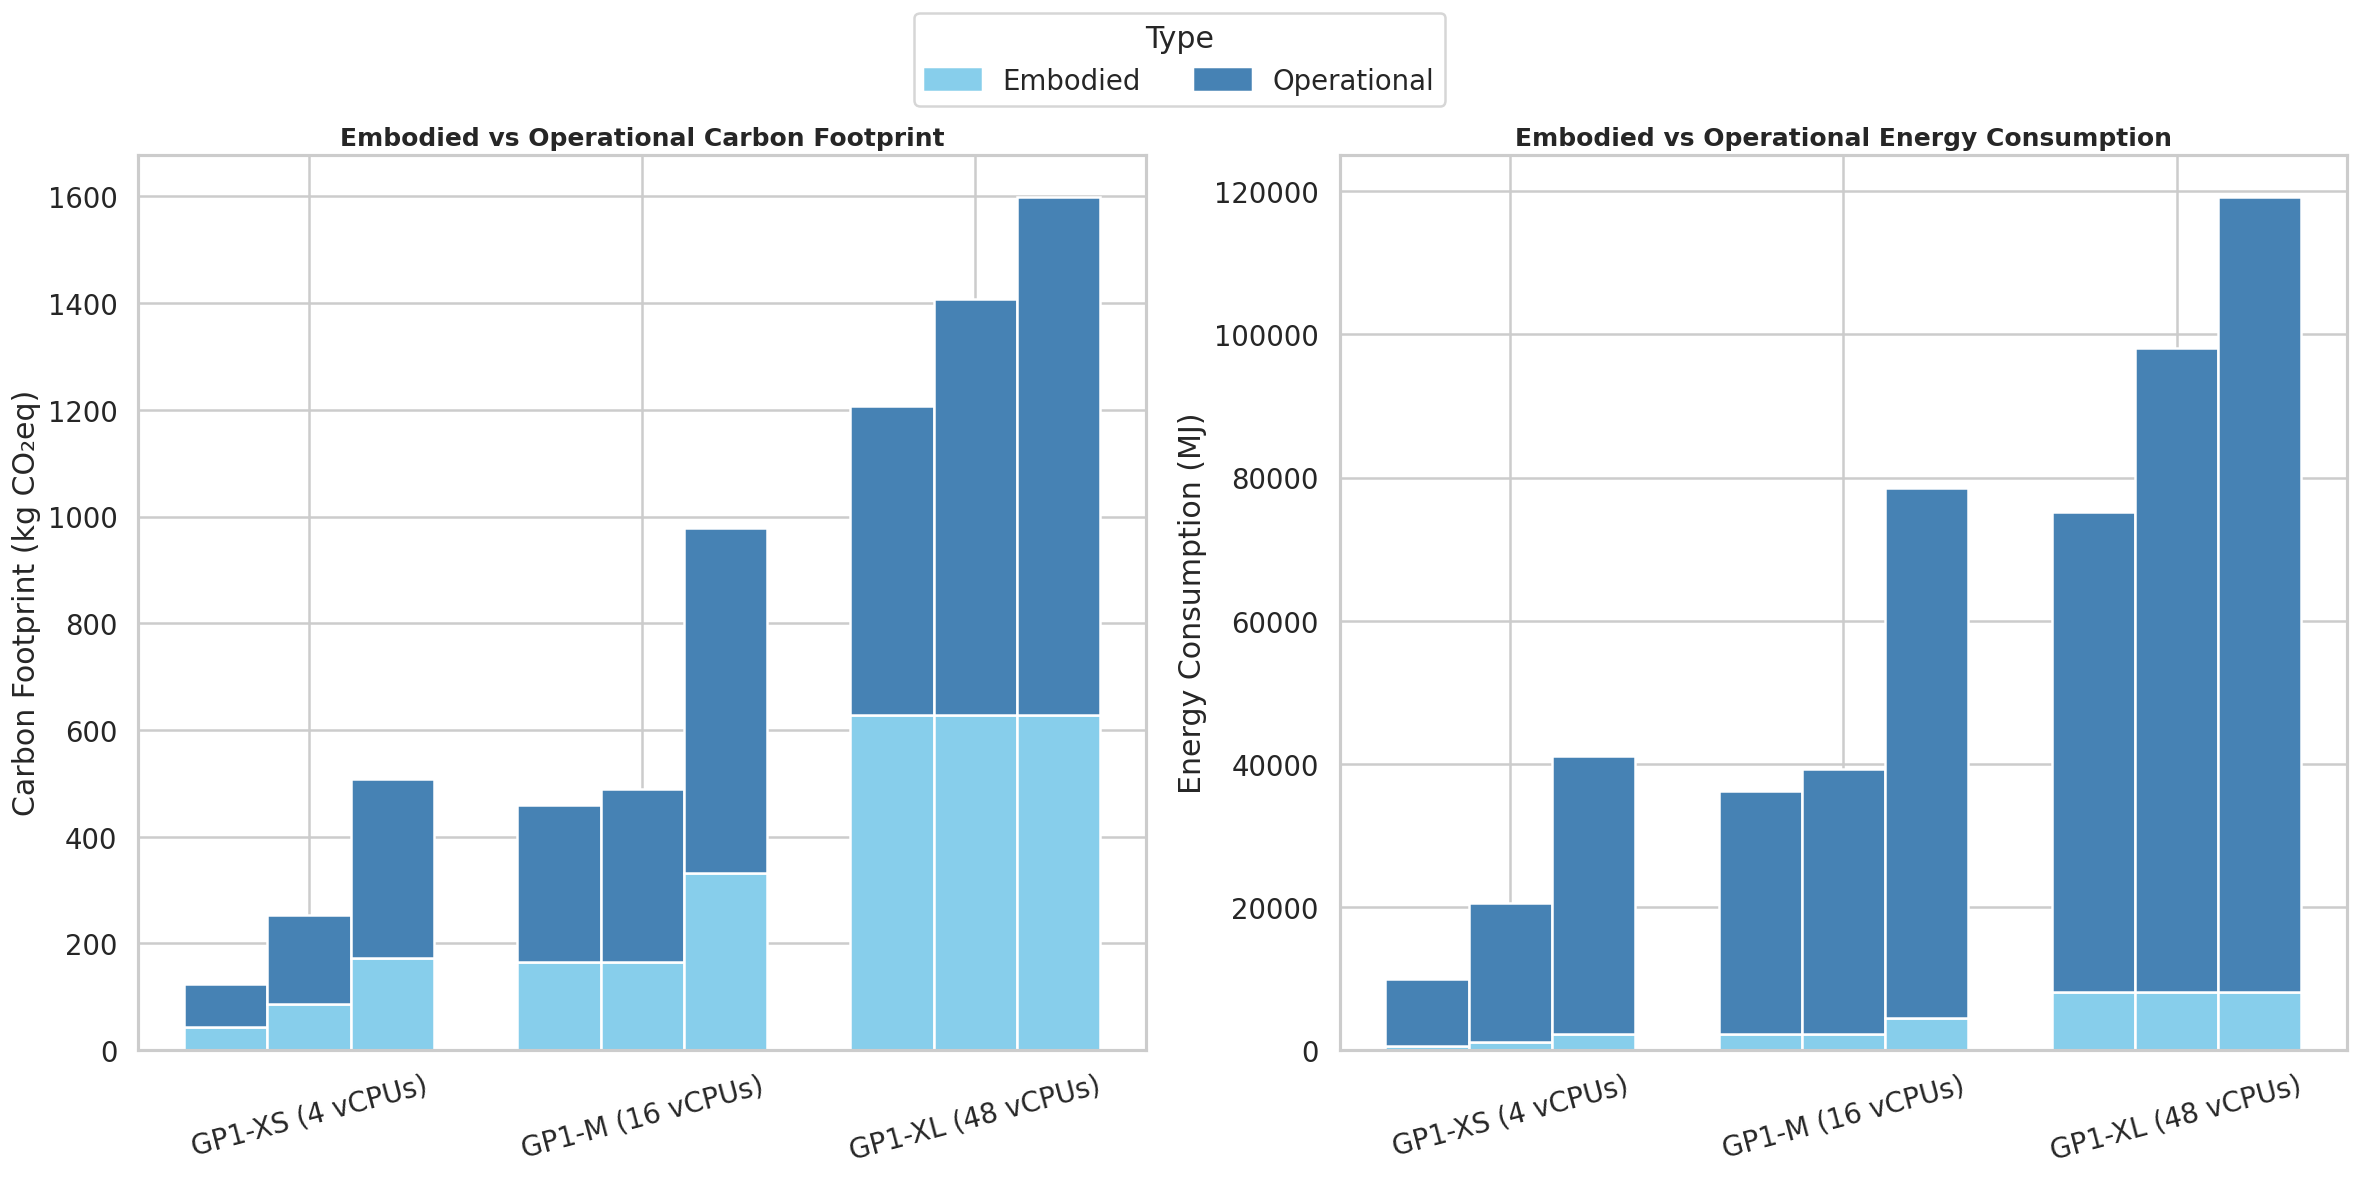

In [22]:
data = [
    {"instance": "GP1-XS (4 vCPUs)", "load": "Idle", "embodied_carbon": "43",  "operational_carbon": "81",  "embodied_energy_mj": "557",  "operational_energy_mj": "9'357"},
    {"instance": "GP1-XS (4 vCPUs)", "load": "Medium", "embodied_carbon": "86",  "operational_carbon": "168", "embodied_energy_mj": "1'114","operational_energy_mj": "19'400"},
    {"instance": "GP1-XS (4 vCPUs)", "load": "Peak", "embodied_carbon": "172", "operational_carbon": "336", "embodied_energy_mj": "2'228","operational_energy_mj": "38'800"},

    {"instance": "GP1-M (16 vCPUs)",  "load": "Idle", "embodied_carbon": "166", "operational_carbon": "294", "embodied_energy_mj": "2'254","operational_energy_mj": "34'000"},
    {"instance": "GP1-M (16 vCPUs)",  "load": "Medium", "embodied_carbon": "166", "operational_carbon": "323", "embodied_energy_mj": "2'254","operational_energy_mj": "37'000"},
    {"instance": "GP1-M (16 vCPUs)",  "load": "Peak", "embodied_carbon": "332", "operational_carbon": "646", "embodied_energy_mj": "4'508","operational_energy_mj": "74'000"},

    {"instance": "GP1-XL (48 vCPUs)", "load": "Idle", "embodied_carbon": "628", "operational_carbon": "580", "embodied_energy_mj": "8'140","operational_energy_mj": "67'000"},
    {"instance": "GP1-XL (48 vCPUs)", "load": "Medium", "embodied_carbon": "628", "operational_carbon": "780", "embodied_energy_mj": "8'140","operational_energy_mj": "90'000"},
    {"instance": "GP1-XL (48 vCPUs)", "load": "Peak", "embodied_carbon": "628", "operational_carbon": "970", "embodied_energy_mj": "8'140","operational_energy_mj": "111'000"},
]

df = pd.DataFrame(data)

# --- Preprocess numeric values ---
for col in df.columns:
    if any(x in col for x in ["carbon", "energy"]):
        df[col] = df[col].str.replace("'", "").astype(float)

# --- Common setup ---
sns.set_theme(style="whitegrid", context="talk", palette="colorblind")
instance_order = ["GP1-XS (4 vCPUs)", "GP1-M (16 vCPUs)", "GP1-XL (48 vCPUs)"]
load_order = ["Idle", "Medium", "Peak"]

# Function to create stacked + grouped bar plots
def plot_stacked_grouped(df, embodied_col, operational_col, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

    bar_width = 0.25
    x = np.arange(len(instance_order))

    for i, load in enumerate(load_order):
        df_load = df[df["load"] == load].set_index("instance").reindex(instance_order)

        embodied = df_load[embodied_col]
        operational = df_load[operational_col]

        # positions offset for each load
        positions = x + (i - 1) * bar_width

        # plot embodied and operational as stacked bars
        ax.bar(positions, embodied, width=bar_width, label=f"{load} - Embodied" if i == 0 else "", color="skyblue")
        ax.bar(positions, operational, bottom=embodied, width=bar_width, label=f"{load} - Operational" if i == 0 else "", color="steelblue")

    ax.set_xticks(x)
    ax.set_xticklabels(instance_order, rotation=15)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontweight="bold", fontsize=16)

    # legend only once
    handles = [
        plt.Rectangle((0,0),1,1, color="skyblue", label="Embodied"),
        plt.Rectangle((0,0),1,1, color="steelblue", label="Operational")
    ]
    ax.legend(handles=handles, title="Type")

    plt.tight_layout()
    plt.show()
    return fig

# --- Plot 1: Carbon footprint ---
figure = plot_stacked_grouped(
    df,
    embodied_col="embodied_carbon",
    operational_col="operational_carbon",
    ylabel="Carbon Footprint (kg CO₂eq)",
    title="Embodied vs Operational Carbon Footprint per Instance Type"
)

save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="datavizta_carbon_footprint_stacked_grouped_barplot"
)

# --- Plot 2: Energy consumption ---
figure = plot_stacked_grouped(
    df,
    embodied_col="embodied_energy_mj",
    operational_col="operational_energy_mj",
    ylabel="Energy Consumption (MJ)",
    title="Embodied vs Operational Energy Consumption per Instance Type"
)

save_plot(
    figure,
    plot_folder=os.path.join(out_folder, "plots"),
    plot_name="datavizta_energy_consumption_stacked_grouped_barplot"
)

plt.show()